# 01_Data_Load_and_Preprocess

## Cel

Celem tego notebooka jest:

- Wczytanie i analiza surowych danych.

- Identyfikacja i przetwarzanie brakujących danych w sposób spójny dla zbioru treningowego i testowego.

- Przygotowanie danych do dalszego modelowania poprzez:

   - Imputację braków,

    - Standaryzację cech numerycznych,

    - Kodowanie zmiennych kategorycznych,

- Zapisanie przetworzonych danych do plików CSV, gotowych do użycia w modelach regresji liniowej (z regularyzacją i bez) oraz w sieciach neuronowych.



## Kroki
**1. Wczytanie danych**

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

train_file_path = "../Data/train.csv"  
test_file_path = "../Data/test.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

**2. Analiza braków danych**

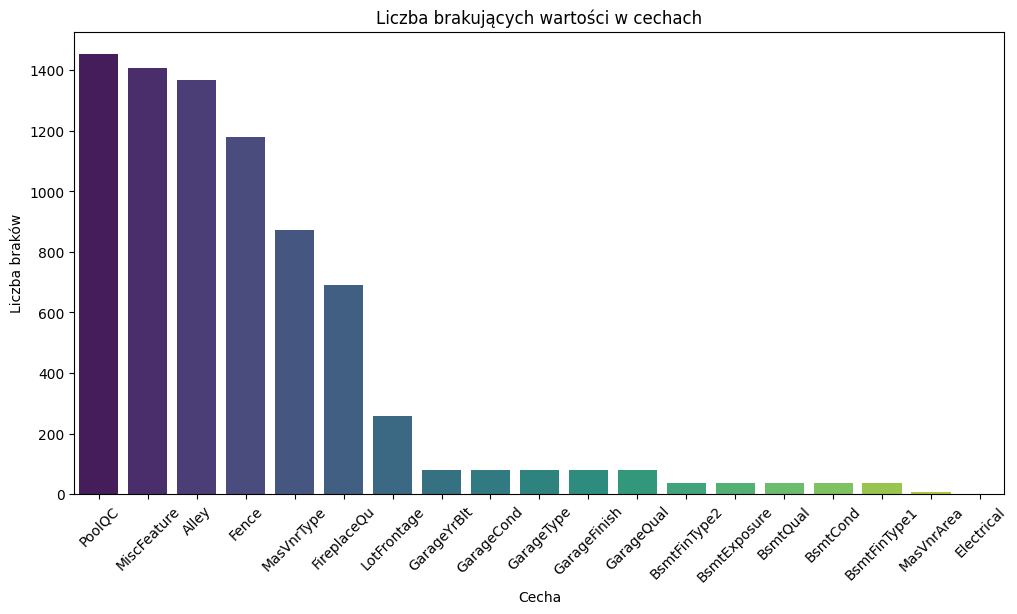

In [28]:
import seaborn as sns

missing_data = train_df.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_data.index, y=missing_data.values, hue=missing_data.index, palette="viridis", dodge=False, legend=False)
plt.title("Liczba brakujących wartości w cechach")
plt.ylabel("Liczba braków")
plt.xlabel("Cecha")
plt.xticks(rotation=45)
plt.show()


**3. Imputacja brakujących danych**

In [29]:


fill_values = {
    'PoolQC': 'None',        
    'MiscFeature': 'None',  
    'Alley': 'None',        
    'Fence': 'None',        
    'FireplaceQu': 'None',  
    'GarageYrBlt': 0,       
    'GarageCond': 'None',   
    'GarageType': 'None',   
    'GarageFinish': 'None', 
    'GarageQual': 'None',   
    'MasVnrType': 'None',   
    'MasVnrArea': 0,        
    'BsmtExposure': 'None', 
    'BsmtFinType2': 'None', 
    'BsmtCond': 'None',     
    'BsmtQual': 'None',     
    'BsmtFinType1': 'None', 
    'Electrical': train_df['Electrical'].mode()[0],  
    'MSZoning': train_df['MSZoning'].mode()[0],  
    'Functional': train_df['Functional'].mode()[0],  
    'Utilities': train_df['Utilities'].mode()[0],  
    'Exterior1st': train_df['Exterior1st'].mode()[0],  
    'Exterior2nd': train_df['Exterior2nd'].mode()[0],  
    'SaleType': train_df['SaleType'].mode()[0],  
    'TotalBsmtSF': train_df['TotalBsmtSF'].median(),  
    'BsmtFinSF1': train_df['BsmtFinSF1'].median(),  
    'GarageCars': train_df['GarageCars'].mode()[0],  
    'GarageArea': train_df['GarageArea'].median(),  
    'KitchenQual': train_df['KitchenQual'].mode()[0],  
    'BsmtFullBath': train_df['BsmtFullBath'].mode()[0],
    'BsmtHalfBath': train_df['BsmtHalfBath'].mode()[0],
    'BsmtUnfSF': train_df['BsmtUnfSF'].median(),
    'BsmtFinSF2': train_df['BsmtFinSF2'].median(), 
    'LotFrontage': train_df.groupby('Neighborhood')['LotFrontage'].transform('median'),
    'MSSubClass': train_df['MSSubClass'].mode()[0],
    'Condition2': train_df['Condition2'].mode()[0],
    'Heating': train_df['Heating'].mode()[0],
    'PavedDrive': train_df['PavedDrive'].mode()[0],
    'SaleCondition': train_df['SaleCondition'].mode()[0],
    '1stFlrSF': train_df['1stFlrSF'].median(),
    '2ndFlrSF': train_df['2ndFlrSF'].median(),
    'LowQualFinSF': train_df['LowQualFinSF'].median(),
    'GrLivArea': train_df['GrLivArea'].median(),
    'FullBath': train_df['FullBath'].mode()[0],
    'HalfBath': train_df['HalfBath'].mode()[0],
    'BedroomAbvGr': train_df['BedroomAbvGr'].mode()[0],
    'KitchenAbvGr': train_df['KitchenAbvGr'].mode()[0],
    'TotRmsAbvGrd': train_df['TotRmsAbvGrd'].mode()[0],
    'Fireplaces': train_df['Fireplaces'].mode()[0],
    'WoodDeckSF': train_df['WoodDeckSF'].median(),
    'OpenPorchSF': train_df['OpenPorchSF'].median(),
    'EnclosedPorch': train_df['EnclosedPorch'].median(),
    '3SsnPorch': train_df['3SsnPorch'].median(),
    'ScreenPorch': train_df['ScreenPorch'].median(),
    'PoolArea': 0,
    'MiscVal': 0,
    'MoSold': train_df['MoSold'].mode()[0],
    'YrSold': train_df['YrSold'].mode()[0]
}

for col, value in fill_values.items():
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(value)
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(value)

print("\nMissing values after imputation:")
print(train_df.isnull().sum().sort_values(ascending=False).head())
print(test_df.isnull().sum().sort_values(ascending=False).head())


Missing values after imputation:
Id             0
CentralAir     0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
dtype: int64
Id             0
MSSubClass     0
GarageType     0
FireplaceQu    0
Fireplaces     0
dtype: int64


**4. Rozdzielenie kolumn na numeryczne i kategoryczne**


In [30]:
categorical_from_file = [
    "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", 
    "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1", 
    "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", 
    "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", 
    "CentralAir", "Electrical", "Functional", "GarageType", "GarageFinish", 
    "PavedDrive", "PoolQC", "Fence", "MiscFeature", "SaleType", "SaleCondition",
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", 
    "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", 
    "FireplaceQu", "GarageQual", "GarageCond"
]

numerical_from_file = [
    "LotFrontage", "LotArea", "OverallQual", "OverallCond", "YearBuilt", 
    "YearRemodAdd", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", 
    "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", 
    "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", 
    "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageYrBlt", "GarageCars", 
    "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", 
    "ScreenPorch", "PoolArea", "MiscVal", "MoSold", "YrSold"
]

special_columns = ["Id", "SalePrice"]

categorical_columns = [col for col in train_df.columns if col in categorical_from_file]
numerical_columns = [col for col in train_df.columns if col in numerical_from_file]
special_columns_in_df = [col for col in train_df.columns if col in special_columns]

all_classified_columns = set(categorical_columns + numerical_columns + special_columns_in_df)
missing_columns = [col for col in train_df.columns if col not in all_classified_columns]

columns_df = pd.DataFrame({
    "Column Name": categorical_columns + numerical_columns + special_columns_in_df + missing_columns,
    "Type": (["Categorical"] * len(categorical_columns)) + 
            (["Numerical"] * len(numerical_columns)) + 
            (["Special"] * len(special_columns_in_df)) + 
            (["Unclassified"] * len(missing_columns))
})

columns_df.to_csv("../Data/columns_classification.csv", index=False)

print(f"Liczba kolumn kategorycznych: {len(categorical_columns)}")
print(f"Liczba kolumn numerycznych: {len(numerical_columns)}")
print(f"Liczba kolumn specjalnych: {len(special_columns_in_df)}")
print(f"Liczba niesklasyfikowanych kolumn: {len(missing_columns)}")
print(f"Liczba wszystkich kolumn: {len(train_df.columns)}")


Liczba kolumn kategorycznych: 44
Liczba kolumn numerycznych: 35
Liczba kolumn specjalnych: 2
Liczba niesklasyfikowanych kolumn: 0
Liczba wszystkich kolumn: 81


**5. Analiza korelacji cech numerycznych z SalePrice**

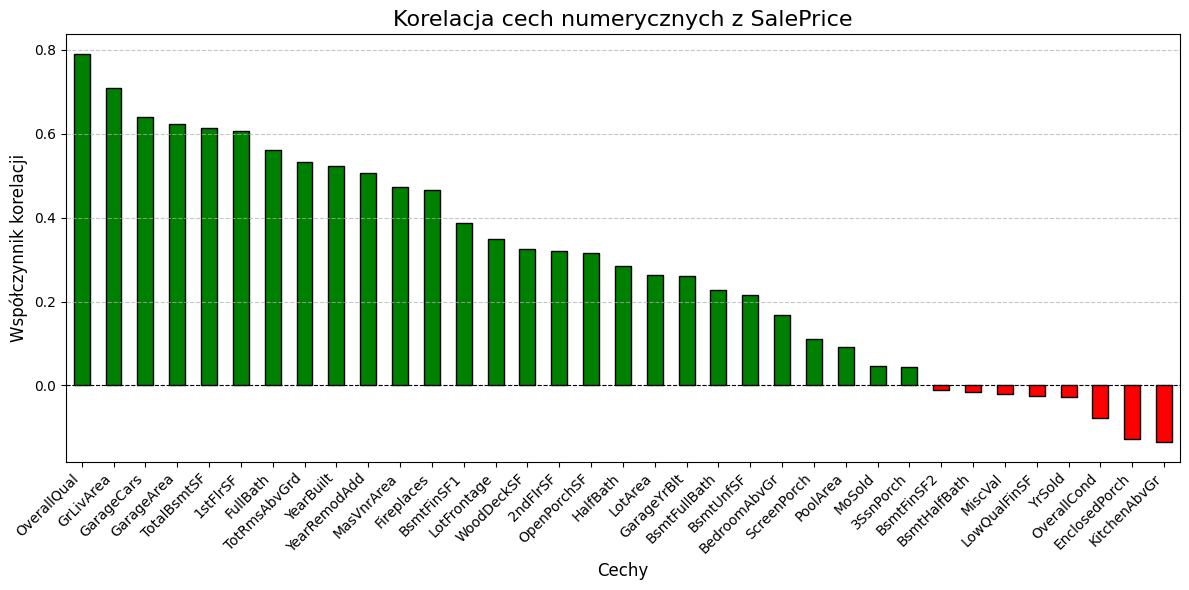

In [31]:
numerical_data = train_df[numerical_columns + ['SalePrice']] 

correlation_with_saleprice = numerical_data.corr()['SalePrice'].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
colors = ['green' if val > 0 else 'red' for val in correlation_with_saleprice.drop('SalePrice')]
correlation_with_saleprice.drop('SalePrice').plot(kind='bar', color=colors, edgecolor='black')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Korelacja cech numerycznych z SalePrice", fontsize=16)
plt.ylabel("Współczynnik korelacji", fontsize=12)
plt.xlabel("Cechy", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**6. Wybór 20 cech numerycznych z najwyższą korelacją**

In [32]:
lowest_corr_features = correlation_with_saleprice.index[40:]

train_df = train_df.drop(columns=lowest_corr_features)
test_df = test_df.drop(columns=lowest_corr_features)

print("Usunięte cechy:", lowest_corr_features.tolist())
print("Pozostałe cechy:", train_df.columns.tolist())

Usunięte cechy: []
Pozostałe cechy: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',

**7. Kodowanie zmiennych kategorycznych (One-hot encoding)**

In [33]:
train_encoded = pd.get_dummies(train_df, columns=categorical_columns, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_columns, drop_first=True)
train_encoded, test_encoded = train_encoded.align(test_encoded, join='inner', axis=1)

train_encoded['SalePrice'] = train_df['SalePrice']

print(f"Liczba cech przed kodowaniem: {len(train_df.columns)}")
print(f"Liczba cech po kodowaniu: {len(train_encoded.columns)}")


Liczba cech przed kodowaniem: 81
Liczba cech po kodowaniu: 256


**8. Skalowanie cech numerycznych do standardowego zakresu**

In [34]:
from sklearn.preprocessing import StandardScaler

numerical_features = [col for col in train_encoded.columns if col in numerical_columns and col != 'SalePrice']

scaler = StandardScaler()

train_encoded[numerical_features] = scaler.fit_transform(train_encoded[numerical_features])
test_encoded[numerical_features] = scaler.transform(test_encoded[numerical_features])


**9. Zapisanie przetworzonych danych do plików CSV**


In [35]:
train_encoded.to_csv('../Data/train_preprocessed.csv', index=False)
test_encoded.to_csv('../Data/test_preprocessed.csv', index=False)

print("Przygotowane dane treningowe zapisano jako 'train_preprocessed.csv'.")
print("Przygotowane dane testowe zapisano jako 'test_preprocessed.csv'.")


Przygotowane dane treningowe zapisano jako 'train_preprocessed.csv'.
Przygotowane dane testowe zapisano jako 'test_preprocessed.csv'.
